#Metodos de suavizacion exponencial. 

Esta seccion trata de el suavizado de los datos en la señal de series temporales. Por ello es necesario dar a conocer la nocion del suavizado de series temporales y cual es su fundamento. 

##Suavizado de series temporales. 

Los datos de las series temporales se componen de señal y ruido, donde la señal captura la dinámica intrínseca del proceso; sin embargo, el ruido representa el componente no modelado de la señal o error aleatorio no correlacionado, el cual en diferentes tiempos es estadísticamente independiente.

La eficacia de la extracción de la tendencia y ruido estimados depende de otros parámetros relacionados con la composición de la señal de la serie temporal, como la presencia de tendencia, estacionalidad y residual (ruido). Para tratar cada uno de estos componentes de las series temporales, se requieren diferentes tratamientos. 

(En este capítulo se tratarán múltiples enfoques de suavización para manejar los diferentes componentes de la señal de la serie temporal)



##Ejemplo de una señal de serie temporal compuesta por tendencia,estacionalidad y ruido blanco.
Es el conjunto de datos de nacimientos mensuales en Nueva York desde enero de 1946 hasta diciembre de 1959. 


In [17]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import requests
import statsmodels.api as sm
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

In [19]:
sns.set_style("darkgrid")

In [20]:
DATA_URL="http://robjhyndman.com/tsdldata/data/nybirths.dat"
fopen = requests.get(DATA_URL).content
ds=pd.read_csv(io.StringIO(fopen.decode('utf-8')),  header=None, names=['birthcount'])
ds.head()

,birthcount
0,26.663
1,23.598
2,26.931
3,24.740
4,25.806


In [21]:
date=pd.date_range("1946-01-01", "1959-12-31", freq="1M")
ds['Date']=pd.DataFrame(date)
ds = ds.set_index('Date')

In [22]:
ds.head()

,birthcount
Date,
1946-01-31,26.663
1946-02-28,23.598
1946-03-31,26.931
1946-04-30,24.740
1946-05-31,25.806


En el cuadro anterior se da a conocer el numero de personas nacidas en los primeros 5 meses del año 1946. 

#Grafica sobre los nacimientos mensuales en Nueva York desde enero de 1946 hasta diciembre de 1959. 

In [23]:
ds.index = pd.to_datetime(ds.index)

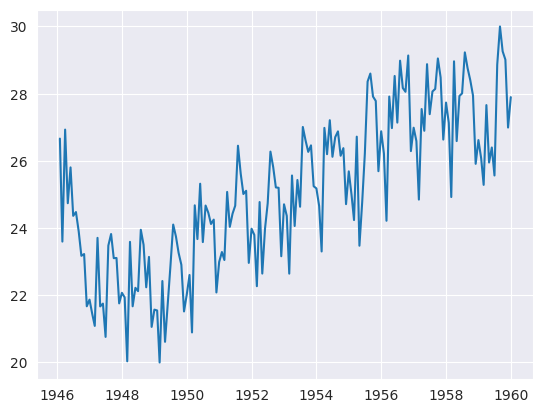

In [24]:
plt.plot(ds.birthcount);

En la grafica anterior se puede observar el cambio en la magnitud de las fluctuaciones con base en las personas nacidas desde enero de 1946 hasta diciembre de 1959. 

Como hacer este tipo de observacion suele ser tedioso, se puede hacer uso de tecnicas basadas en el calculo del termino (St+Et) o factor (St x Et). 

Asi, debemos considerar que si las fluctuaciones obtenidas son iguales, es decir que su amplitud es la misma concluimos que la serie de tiempo es aditiva. Pero si se realiza el caso contrario, es decir que la amplitud no sea la misma seria de tipo multiplicativo. 

##Grafica de serie de tiempo multiplicativa. 

In [25]:
figure_kwargs = {'figsize': (6, 6)}

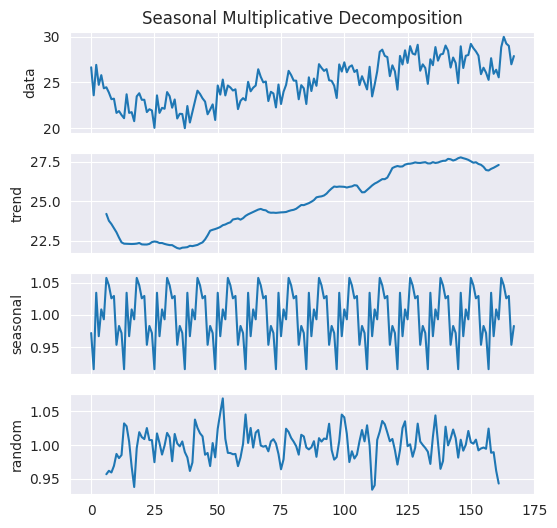

In [26]:
decomposed = arima.decompose(ds.birthcount.values, 'multiplicative', m=12)
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Seasonal Multiplicative Decomposition");

En la grafica anterior podemos darnos cuenta que la magnitud del componente estacional cambia con el tiempo, por lo tanto consideramos que la serie es multiplicativa. 

Su formula es la siguiente: 

yt= ft x st x Et

##A continuacion se da a conocer una serie de tipo aditivo, para poder diferenciarla del multiplicativo. 

In [27]:
import datetime

In [28]:
dates_airpass = pd.date_range(start='1949-01', periods=len(datasets.load_airpassengers()), freq='M').strftime('%Y-%m')
air_pass_df = pd.DataFrame({'Date': dates_airpass.tolist(),
                            'Passengers': datasets.load_airpassengers().tolist()})
air_pass_df.head()

,Date,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [29]:
beer_aust = pd.read_csv('/content/drive/MyDrive/datasets/quarterly-beer-production-in-aus-March 1956-June 1994.csv')
beer_aust.rename(columns={"Quarterly beer production in Australia: megalitres. March 1956 ? June 1994": "beer_prod"}, inplace=True)
beer_aust.head()

,Quarter,beer_prod
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0


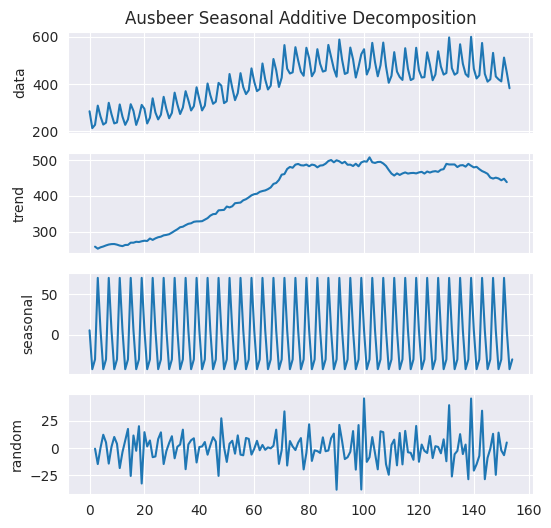

In [30]:
decomposed = arima.decompose(beer_aust.beer_prod, 'additive', m=4)
axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs, show=False)
axes[0].set_title("Ausbeer Seasonal Additive Decomposition");

La grafica anterior nos da a conocer que la magnitud del componente estacional no cambia a medida que va pasando el tiempo, por lo tanto consideramos que la serie en este caso es de tipo aditivo. 

#Propiedades de estacionalidad aditiva y multiplicativa

Se pueden estimar de manera experimental de la siguiente forma:

#1.
Si la estacionalidad es aditiva, entonces el resultado de la resta entre la serie de tiempo origina y su media movil tendrá fluctuaciones casi similares en magnitud.

 

#2.
Si es multiplicativa, entonces el resultado de la división tiene la siguiente propiedad:

Para ello acontinuacion se dara a conocer un ejemplo. 

In [31]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return pd.DataFrame(np.convolve(interval, window, 'same'), columns=['MA'])

In [32]:
dates_airpassl = dates_airpass.tolist()

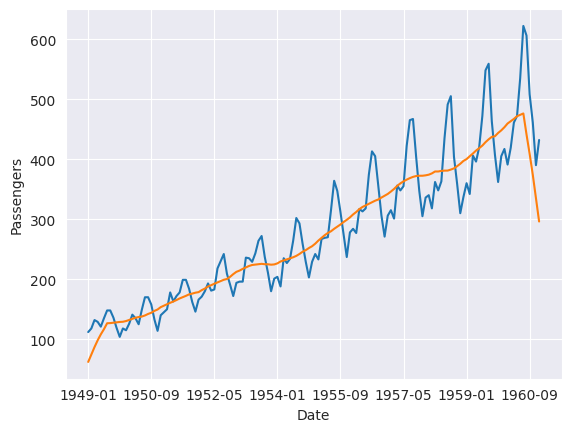

In [33]:
fig, ax = plt.subplots()
ax.plot(dates_airpassl, datasets.load_airpassengers())
ax.plot(dates_airpassl, movingaverage(datasets.load_airpassengers(), 12));
freq = int(20)
ax.set_xticks(dates_airpassl[::freq]);
ax.set_xticklabels(dates_airpassl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');

En la grafica anterior se puede observar el cambio en la magnitud de las fluctuaciones con base en los pasajeros desde enero de 1949 hasta septiembre de 1960. 

Como la amplitud aumenta con el tiempo, se considera que la serie anterior es de tipo multiplicativo. 

A su vez, es necesario tener en cuenta que la media movil (Linea naranja) al final del periodo tiende a decrecer, esto se da porque ya no hay mas datos que permitan continuar con el estudio, es ahi donde se establece nuevamente la secuencia. 

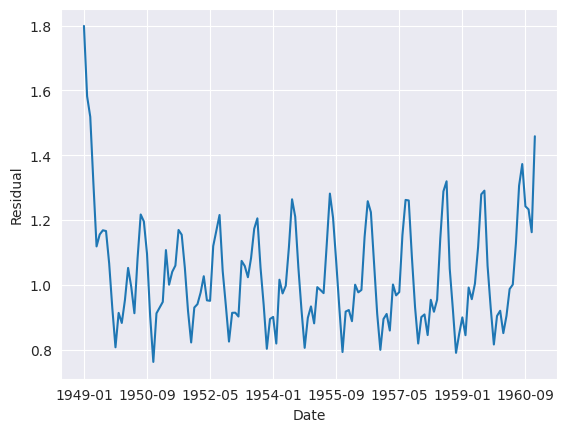

In [34]:
fig, ax = plt.subplots()
ax.plot(dates_airpassl, datasets.load_airpassengers()/movingaverage(datasets.load_airpassengers(), 12).MA.values);
freq = int(20)
ax.set_xticks(dates_airpassl[::freq]);
ax.set_xticklabels(dates_airpassl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Residual');

En la grafica anterior nos damos cuenta que el residuo para la respectiva serie temporal es de estacionalidad multiplicativa porque su varianzase ve sometida a cambios con cada periodo de frecuencia. 

In [35]:
dates_beerpl = beer_aust.Quarter.tolist()

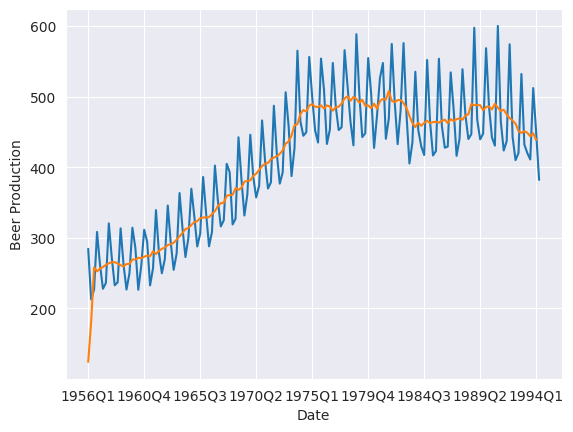

In [36]:
fig, ax = plt.subplots()
ax.plot(dates_beerpl, beer_aust.beer_prod)
ax.plot(movingaverage(beer_aust.beer_prod, 4));
freq = int(19)
ax.set_xticks(dates_beerpl[::freq]);
ax.set_xticklabels(dates_beerpl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Beer Production');

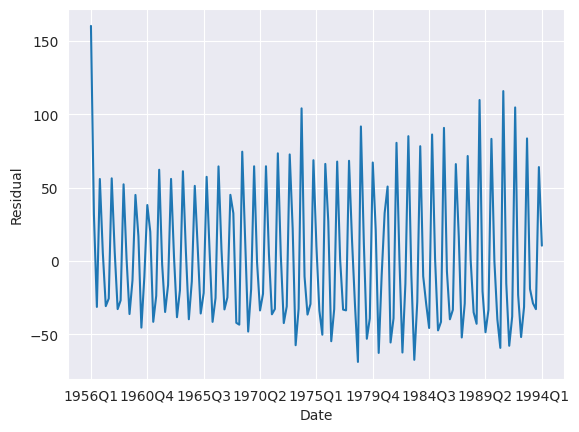

In [37]:
fig, ax = plt.subplots()
ax.plot(dates_beerpl, beer_aust.beer_prod-movingaverage(beer_aust.beer_prod, 4).MA.values);
freq = int(19)
ax.set_xticks(dates_beerpl[::freq]);
ax.set_xticklabels(dates_beerpl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Residual');

Si calculamos el residuo para una serie temporal con estacionalidad multiplicativa, la serie resultante contiene componentes estacionales cuya varianza aumenta cada periodo de frecuencia.

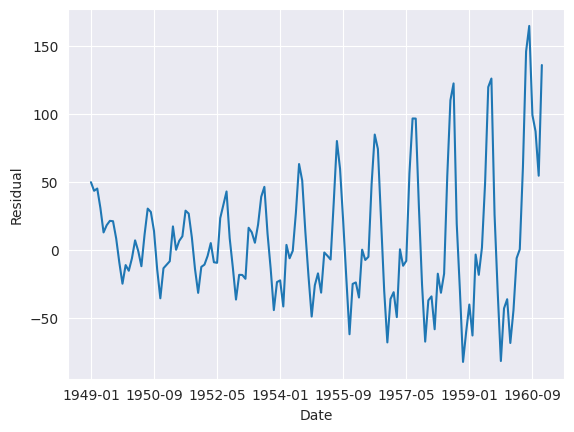

In [38]:
fig, ax = plt.subplots()
ax.plot(dates_airpassl, datasets.load_airpassengers()-movingaverage(datasets.load_airpassengers(), 12).MA.values);
freq = int(20)
ax.set_xticks(dates_airpassl[::freq]);
ax.set_xticklabels(dates_airpassl[::freq]);
ax.set_xlabel('Date');
ax.set_ylabel('Residual');

En esta grafica al igual se evidencia de manera mas clara el comportamiento de una serie temporal con estacionalidad multiplicativa, ya que su periocidad va en aumento amedida que pasan los años. 

#Importancia de las pruebas no parametrica para verificar estacionalidad sin usar visualizaciones. 

Una alternativa para verificar estacionalidad sin usar visualizaciones, es utilizar una prueba no paramétrica (ver Kruskal-Wallis test). Este test comprueba la correlación entre la observación real y la observación retardada. Si las observaciones son independientes entre sí, siguen una distribución chi cuadrado. Cuando se rechaza esta hipótesis, se confirma una autocorrelación significativa, que es señal de movimientos estacionales en la serie.

In [39]:
from scipy.stats import kruskal

def seasonality_test(series, period):
        seasonal = False
        idx = np.arange(len(series)) % period
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal

In [40]:
print("Is the Air Passengers time series seasonal?:", seasonality_test(dates_airpassl, 12))

Is the Air Passengers time series seasonal?: True


In [41]:
print("Is the Beer production time series seasonal?:", seasonality_test(beer_aust.beer_prod, 4))

Is the Beer production time series seasonal?: False


La señal de la serie temporal anterior está compuesta por la tendencia, la estacionalidad y el residuo (ruido blanco). El suavizado ayuda a eliminar el componente residual y capta los componentes de tendencia y estacionalidad para la predicción de la señal.

El primer paso del modelo para incluir la media, la tendencia y los patrones no estacionales es extrapolarla mediante la suavización. 

Por lo general, la media móvil simple se realiza sobre ventanas de predicción; así, la predicción estimada se evalua en ventanas óptimas con el objetivo de minimizar la función de error

#Suavizacion exponencial de primer orden

A continuacion se tomara como ejemplo el precio de cierre de las acciones de IBM para pronosticarlo utilizando el método de suavizado simple. El primer paso es cargar los módulos necesarios

In [42]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [43]:
ibm_df = pd.read_csv('/content/drive/MyDrive/datasets/ibm-common-stock-closing-prices.csv')
ibm_df.head()

,Date,IBM common stock closing prices
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


Se establece un cambio del nombre de las columnas para mayor comodidad. 

In [44]:
ibm_df.rename(columns={'IBM common stock closing prices': 'Close_Price'}, inplace=True)
ibm_df.head()

,Date,Close_Price
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


En el método de suavización exponencial simple, los valores predichos se generan como sigue usando Ec. (6). Esta serie se puede implementar en Python de la siguiente manera:

In [45]:
def single_exp_smoothing(x, alpha):
    F = [x[0]]
    for t in range(1, len(x)):
        F.append(alpha * x[t] + (1 - alpha) * F[t-1])
    return F

La función single_exp_smoothing configurada con el valor inicial previsto se asigna como el primer valor de la serie. Evaluemos primero los casos extremos de previsión con alfa igual 0 y alfa igual 1. 

In [46]:
ibm_df['SES0'] = single_exp_smoothing(ibm_df['Close_Price'], 0)
ibm_df['SES1'] = single_exp_smoothing(ibm_df['Close_Price'], 1)

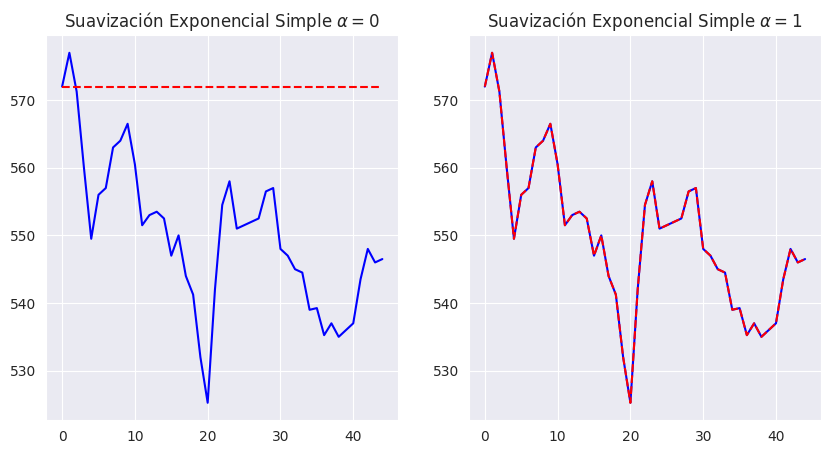

In [47]:
f, axarr = plt.subplots(1, 2, sharex=True)
f.set_size_inches(10, 5)


ibm_df['Close_Price'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0])
ibm_df['SES0'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title(r'Suavización Exponencial Simple $\alpha=0$');

ibm_df['Close_Price'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1])
ibm_df['SES1'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[1])
axarr[1].set_title(r'Suavización Exponencial Simple $\alpha=1$');

En la figura anterior se ilustra que para alfa igual a 0 la prediccion es una constante y para alfa igual a 1 la serie pronosticada se desplaza en desfase temporal. 

El pronóstico de alisamiento único para valores de suavización 0.2   0.6   0.8 puede evaluarse de la siguiente manera:

In [48]:
ibm_df['SES2'] = single_exp_smoothing(ibm_df['Close_Price'], 0.2)
ibm_df['SES6'] = single_exp_smoothing(ibm_df['Close_Price'], 0.6)
ibm_df['SES8'] = single_exp_smoothing(ibm_df['Close_Price'], 0.8)

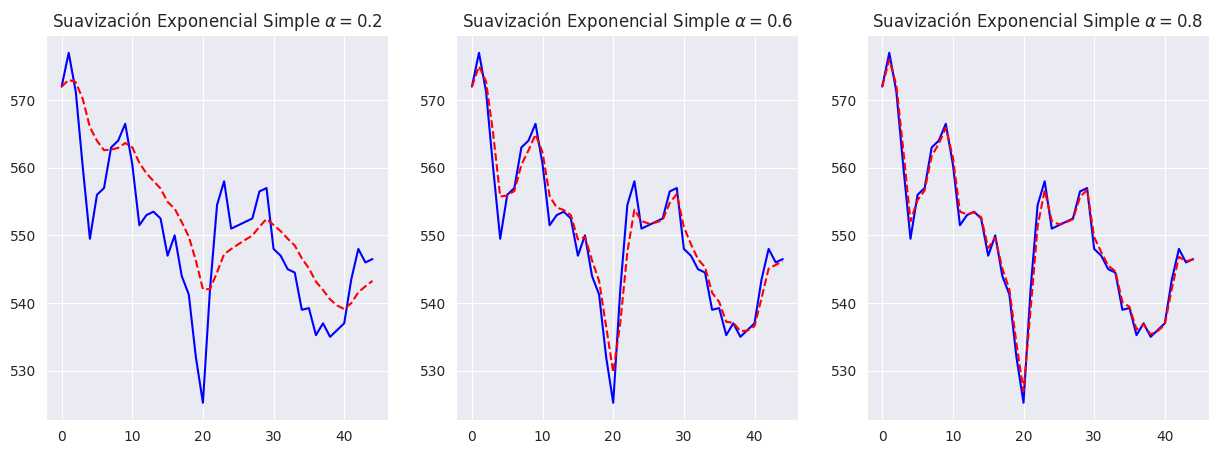

In [49]:
f, axarr = plt.subplots(1, 3, sharex=True)
f.set_size_inches(15, 5)

ibm_df['Close_Price'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0])
ibm_df['SES2'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0])
axarr[0].set_title(r'Suavización Exponencial Simple $\alpha=0.2$');

ibm_df['Close_Price'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1])
ibm_df['SES6'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[1])
axarr[1].set_title(r'Suavización Exponencial Simple $\alpha=0.6$');

ibm_df['Close_Price'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[2])
ibm_df['SES8'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[2])
axarr[2].set_title(r'Suavización Exponencial Simple $\alpha=0.8$');

La figura anterior ilustra que alfa tiene un gran impacto en la previsión; por lo tanto, obtener el valor correcto de alfa es fundamental a la hora de establecer la previsión.

#Suavización exponencial de segundo orden

El suavizado exponencial de segundo orden ayuda a capturar la tendencia en los datos de serie temporal incluyendo otro término en el suavizado exponencial de primer orden.

##Ejemplo

In [50]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [52]:
beer_df = pd.read_csv('/content/drive/MyDrive/datasets/quarterly-beer-production-in-aus-March 1956-June 1994.csv')
print('Dimensión del dataframe:', beer_df.shape)

beer_df.rename(columns={'Quarterly beer production in Australia: megalitres. March 1956 ? June 1994':'Beer_Prod'},
               inplace=True)
    
missing = (pd.isnull(beer_df['Quarter'])) | (pd.isnull(beer_df['Beer_Prod']))
print('Número de filas con al menos un valor igual a cero:', missing.sum())
beer_df = beer_df.loc[~missing, :]

print('Dimensiones después de eliminar los valores perdidos:', beer_df.shape)
beer_df.head()

Dimensión del dataframe: (155, 2)
Número de filas con al menos un valor igual a cero: 1
Dimensiones después de eliminar los valores perdidos: (154, 2)


,Quarter,Beer_Prod
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0


A continuacion se crea la funcion para el suavizado exponencial doble. 

In [53]:
def double_exp_smoothing(x, alpha, beta):
    yhat = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        if t==1:
            F, T= x[0], x[1] - x[0]
        F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
        T=beta*(F-F_n_1)+(1-beta)*T
        yhat.append(F+T)
    return yhat

La función anterior toma como entrada la serie temporal x con alpha y beta. La implementación anterior utiliza la diferencia de las dos primeras ocurrencias para establecer el valor de la tendencia inicial. 

Vamos a evaluar el rendimiento en los casos límite, es decir, (alpha, beta) para (0,0),(0,1),(1,0) y (1,1). 

In [54]:
beer_df['DEF00'] = double_exp_smoothing(beer_df['Beer_Prod'], 0, 0)
beer_df['DEF01'] = double_exp_smoothing(beer_df['Beer_Prod'], 0, 1)
beer_df['DEF10'] = double_exp_smoothing(beer_df['Beer_Prod'], 1, 0)
beer_df['DEF11'] = double_exp_smoothing(beer_df['Beer_Prod'], 1, 1)

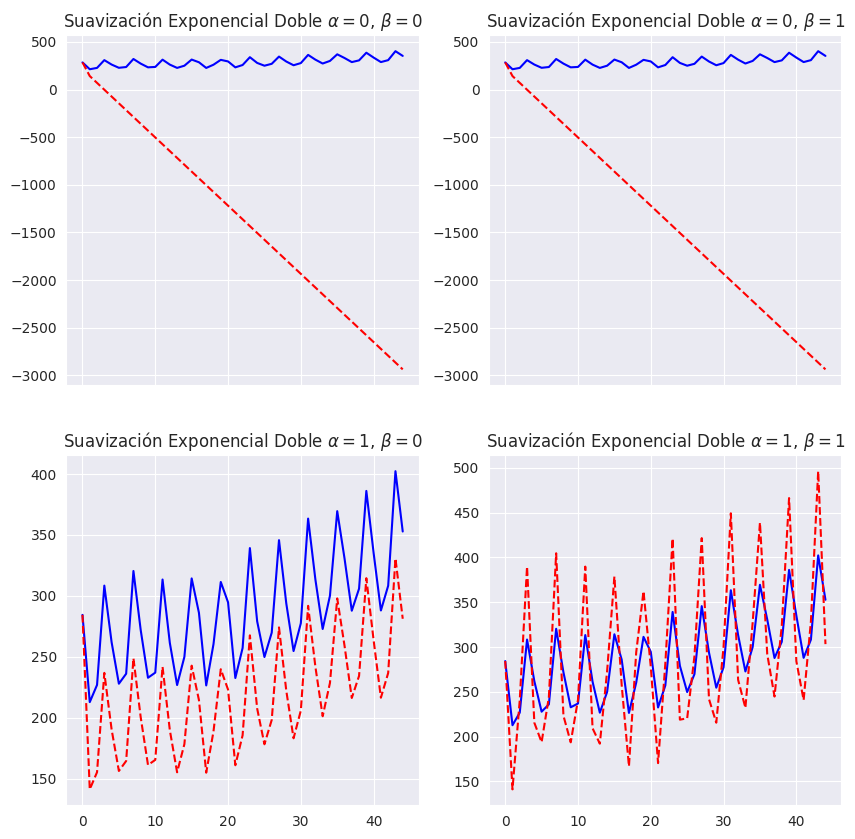

In [55]:
f, axarr = plt.subplots(2, 2, sharex=True)
f.set_size_inches(10, 10)

beer_df['Beer_Prod'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0, 0])
beer_df['DEF00'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0, 0])
axarr[0, 0].set_title(r'Suavización Exponencial Doble $\alpha=0,\,\beta=0$')

beer_df['Beer_Prod'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[0, 1])
beer_df['DEF01'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[0, 1])
axarr[0, 1].set_title(r'Suavización Exponencial Doble $\alpha=0,\,\beta=1$')

beer_df['Beer_Prod'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1, 0])
beer_df['DEF10'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[1, 0])
axarr[1, 0].set_title(r'Suavización Exponencial Doble $\alpha=1,\,\beta=0$');

beer_df['Beer_Prod'].iloc[:45].plot(color='b', linestyle = '-', ax=axarr[1, 1])
beer_df['DEF11'].iloc[:45].plot(color='r', linestyle = '--', ax=axarr[1, 1])
axarr[1, 1].set_title(r'Suavización Exponencial Doble $\alpha=1,\,\beta=1$');

Cuando alpha=0, los valores iniciales permanecen constantes; por lo tanto, el parámetro de tendencia no desempeña ningún papel.

La predicción en el tiempo depende del valor anterior y de los componentes de tendencia. Como beta se fija en 0 entonces el componente de tendencia en t-1 dependera de su secuencia. 

##Realizamos a continuación un suavizado exponencial doble con los datos de producción de cerveza utilizando valores intermedios de alpha y beta de la siguiente manera:

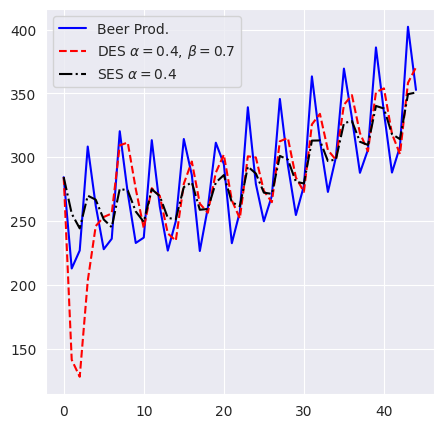

In [56]:
beer_df['DEF'] = double_exp_smoothing(beer_df['Beer_Prod'], 0.4, 0.7)
beer_df['Single_Exponential_Forecast'] = single_exp_smoothing(beer_df['Beer_Prod'], 0.4)

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
beer_df['Beer_Prod'].iloc[:45].plot(color='b', linestyle = '-', label = 'Beer Prod.')
beer_df['DEF'].iloc[:45].plot(color='r', linestyle = '--', label = r'DES $\alpha=0.4,\,\beta=0.7$')
beer_df['Single_Exponential_Forecast'].iloc[:45].plot(color='k', linestyle = '-.', label = r'SES $\alpha=0.4$')
leg = ax.legend();

La figura anterior muestra que el suavizado exponencial doble es capaz de capturar mejor la variación de la señal real para el conjunto de datos actual en comparación con el suavizado exponencial simple. Sin embargo, en los escenarios en los que el componente de tendencia tienden a cero, el rendimiento del suavizado exponencial simple y doble es comparable.

##Suavización exponencial de orden superior

En este caso, se trata de pesos para los suavizadores. Normalmente, la suavización exponencial de orden superior no se utiliza, el cálculo es muy difícil, mas bien, se utilizan modelos Autorregrsivos Integrados de Media Movil(ARIMA) los cuales se tratarán con más detalle en la siguiente sección.


Otro suavizado exponencial muy popular es el suavizado exponencial triple  (Holt Winters). El suavizado exponencial triple permite capturar la estacionalidad con el nivel (valor suavizado de la parte constante en el tiempo) y la tendencia.

Usemos suavización exponencial triple para los datos de empleo de Wisconsin.

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Shape of the DataFrame: (178, 2)


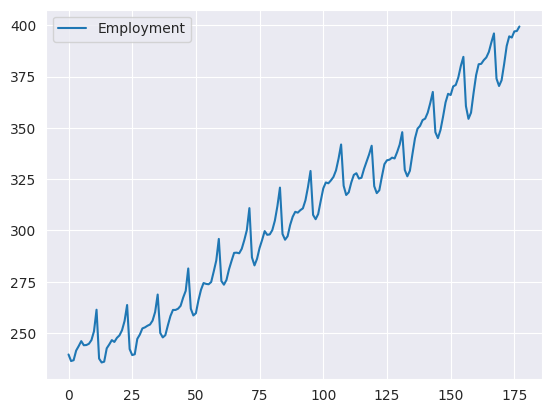

In [58]:
wisc_emp = pd.read_csv('/content/drive/MyDrive/datasets/wisconsin-employment-time-series.csv')
print('Shape of the DataFrame:', wisc_emp.shape)
wisc_emp.head();
wisc_emp.plot();

La figura anterior muestra el conjunto de datos de series temporales, Employment de Wisconsin. El conjunto de datos consta de tendencia anual y estacionalidad mensual.

Dado que el patrón de estacionalidad de los datos es conocido, la información sobre la estacionalidad puede utilizarse para derivar el valor inicial de la tendencia como el valor medio de las estaciones haciendo uso de la siguiente ecuacion:

In [60]:
def initialize_T(x, seasonLength):
    total=0.0
    for i in range(seasonLength):
        total+=float(x[i+seasonLength]-x[i])/seasonLength
    return total

##Ejemplo

el valor de tendencia inicial generado por la función anterior es utilizando el script initialize_T()

In [61]:
initialize_T(wisc_emp['Employment'], 12)

1.6916666666666653

La estacionalidad inicial es de suma importancia y se puede calcular con la siguiente función. Los valores iniciales de las estaciones se calculan como valor medio de la respuesta x. 

In [62]:
def initialize_seasonalilty(x, seasonLength):
    seasons={}
    seasonsMean=[]
    num_season=int(len(x)/seasonLength)

    for i in range(num_season):
        seasonsMean.append(sum(x[seasonLength*i:seasonLength*i+seasonLength])/float(seasonLength))
    
    for i in range(seasonLength):
        tot=0.0
        for j in range(num_season):
            tot+=x[seasonLength*j+i]-seasonsMean[j]
        seasons[i]=tot/num_season
    return seasons

In [63]:
initialize_seasonalilty(wisc_emp['Employment'], 12)   

{0: -11.325000000000015,
 1: -14.48214285714287,
 2: -12.667857142857159,
 3: -6.403571428571445,
 4: -1.603571428571444,
 5: 1.5535714285714164,
 6: 1.0821428571428413,
 7: 2.22499999999998,
 8: 3.539285714285705,
 9: 6.89642857142856,
 10: 11.774999999999986,
 11: 19.410714285714267}

Una vez obtenidos los valores, estamos listos para establecer la predicción utilizando suavización exponencial triple

In [64]:
def triple_exp_smoothing(x, seasonLength, alpha, beta, gamma, h):
    yhat=[]
    S = initialize_seasonalilty(x, seasonLength)
    for i in range(len(x)+h):
        if i == 0:
            F = x[0]
            T = initialize_T(x, seasonLength)
            yhat.append(x[0])
            continue
        if i >= len(x):
            m = i - len(x) + 1
            yhat.append((F + m*T) + S[i%seasonLength])
        else:
            obsval = x[i]
            F_last, F= F, alpha*(obsval-S[i%seasonLength]) + (1-alpha)*(F+T)
            T = beta * (F-F_last) + (1-beta)*T
            S[i%seasonLength] = gamma*(obsval-F) + (1-gamma)*S[i%seasonLength]
            yhat.append(F+T+S[i%seasonLength])
    return yhat

La suavización exponencial triple está controlada por alpha, beta y gamma. La presencia o ausencia de cualquier escenario tendrá un efecto drástico en el resultado. Hagamos una comparación empírica para diferentes escenarios extremos. Vamos a ejecutar el suavizado exponencial con parámetros intermedios, como se muestra en la siguiente figura:

In [65]:
wisc_emp['TES']=triple_exp_smoothing(wisc_emp['Employment'], 12, 0.4, 0.6, 0.2, 0)

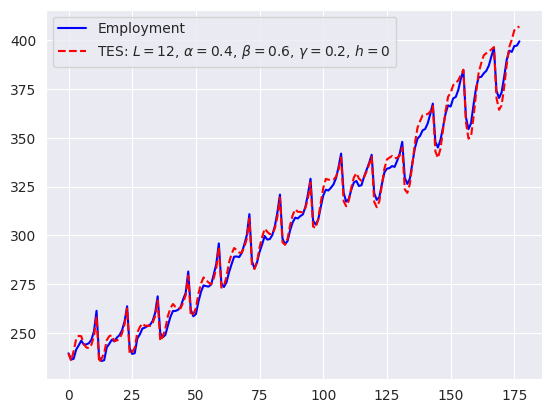

In [66]:
fig = plt.figure()
ax = fig.add_subplot()

wisc_emp['Employment'].plot(ax=ax, color='b', linestyle = '-', label = 'Employment')
wisc_emp['TES'].plot(ax=ax, color='r', linestyle = '--', 
                     label = r'TES: $L=12,\,\alpha=0.4,\,\beta=0.6,\,\gamma=0.2,\,h=0$')
leg = ax.legend();

Comparemos este ajuste con las suavizaciones de primer y segundo orden. 

Al realizar el proceso se obtiene lo siguiente:

In [67]:
wisc_emp['DES'] = double_exp_smoothing(wisc_emp['Employment'], 0.4, 0.6)
wisc_emp['SES'] = single_exp_smoothing(wisc_emp['Employment'], 0.4)

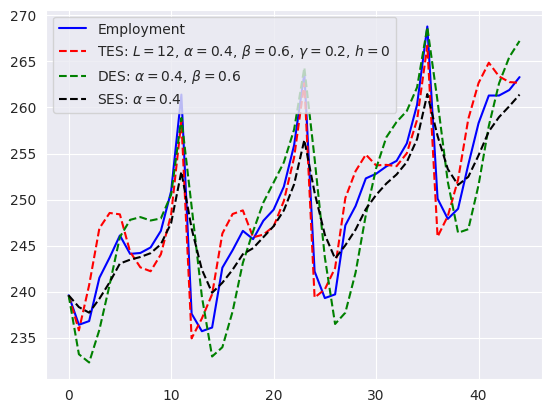

In [68]:
fig = plt.figure()
ax = fig.add_subplot()

wisc_emp['Employment'].iloc[:45].plot(ax=ax, color='b', linestyle = '-', label = 'Employment')
wisc_emp['TES'].iloc[:45].plot(ax=ax, color='r', linestyle = '--', 
                     label = r'TES: $L=12,\,\alpha=0.4,\,\beta=0.6,\,\gamma=0.2,\,h=0$')
wisc_emp['DES'].iloc[:45].plot(ax=ax, color='g', linestyle = '--', label = r'DES: $\alpha=0.4,\,\beta=0.6$')
wisc_emp['SES'].iloc[:45].plot(ax=ax, color='k', linestyle = '--', label = r'SES: $\alpha=0.4$')
leg = ax.legend();

Según los estudios numéricos, el nivel único que utiliza el suavizado o la estacionalidad es capaz de capturar tendencia en los datos; por tanto, todos los modelos funcionaron bien, ya que el suavizado exponencial simple y el doble fueron capaces de utilizar el factor de suavización para hacer las predicciones y la suavización exponencial triple es capaz de capturas las predicciones utilizando los factores de suavización o estacionalidad.

#RESUMEN

Este capítulo trata de los enfoques de suavización exponencial para datos de series temporales. Los enfoques pueden ampliarse fácilmente para la predicción mediante la inclusión de términos como el factor de suavización, factor de tendencia y factor de estacionalidad.

 se han tratado todos estos modelos en detalle con su implementación en Python. El enfoque de suavizado exponencial puede utilizarse para pronosticar series temporales estacionarias. Sin embargo, esta suposición puede no ser cierta. Se recomienda el suavizado exponencial de orden superior para estos casos, pero su cálculo es difícil y costoso computacionalmente. Por lo tanto, para hacer frente a este planteamiento, se utilizan otras técnicas de previsión como el modelo ARIMA. 